In [1]:
import matplotlib.pyplot as plt
import numpy as np 

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D

 
import warnings
warnings.filterwarnings('ignore')

En esta notebook estaré usando un dataset con fotos de rayos-X , intentando predecir si la persona de la foto tiene covid-19, tuberculosis, neumonía o si está sano
- Primero importamos el dataset y creamos un ImageDataGenerator para poder generar nuevas imagenes a partir de pequeños cambios en las imagenes originales, es decir que aumentaremos nuestro dataset (data augmentation) y así poder tener más instancias para entrenar el modelo. Creamos un imageGenerator para cada tipo de dato (train, test, validation) para garantizar que todas las imagenes que reciba la red estén en un mismo formato

In [2]:
train_dir = 'data/train'
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 10,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.2,
							zoom_range = 0.2,
							#horizontal_flip = True
							)

train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 32,
							class_mode ='categorical')

val_dir = 'data/val'						
val_datagen = ImageDataGenerator(1./255)
val_generator = val_datagen.flow_from_directory(
							val_dir,
							target_size = (150,150),
							batch_size =32,
							class_mode= 'categorical')

test_dir = 'data/test'
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 32,
					class_mode= 'categorical')

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


- Primero intentemo crear un modelo secuencial simple, con algunas capas convolucionales alternadas con unas de MaxPooling, para luego pasar los features de la imagen en forma de un arreglo plano hacia una capa densa. 
- Usamos softmax como función de activación final porque tenemos un problema de multiples clases y esta función ayudará a tener los porcentajes de pertenencia hacia cada clase

In [16]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = "relu", input_shape = (150,150,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Flatten())
#model.add(Dense(256, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

In [17]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 64)      4864      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 32)        51232     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 36992)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                

In [20]:
# fit model
history = model.fit(train_generator,
                    #steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    #validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
317/317 [==============================] - 270s 848ms/step - loss: 0.9122 - accuracy: 0.6489 - val_loss: 287.0907 - val_accuracy: 0.3947
Epoch 2/10
317/317 [==============================] - 272s 857ms/step - loss: 0.6866 - accuracy: 0.7445 - val_loss: 229.7079 - val_accuracy: 0.5263
Epoch 3/10
317/317 [==============================] - 269s 848ms/step - loss: 0.5869 - accuracy: 0.7811 - val_loss: 98.5215 - val_accuracy: 0.6316
Epoch 4/10
317/317 [==============================] - 271s 854ms/step - loss: 0.5790 - accuracy: 0.7830 - val_loss: 317.4187 - val_accuracy: 0.4737
Epoch 5/10
317/317 [==============================] - 272s 858ms/step - loss: 0.5459 - accuracy: 0.7975 - val_loss: 112.7983 - val_accuracy: 0.7105
Epoch 6/10
317/317 [==============================] - 268s 846ms/step - loss: 0.4919 - accuracy: 0.8157 - val_loss: 123.0335 - val_accuracy: 0.6579
Epoch 7/10
317/317 [==============================] - 299s 943ms/step - loss: 0.4845 - accuracy: 0.8250 - val_los

Como podemos ver, alcanzamos un accuracy de validación de aproximadamente 70% , lo cual no está bien, sobre todo considerando que el accuracy de entrenamiento está arriba del 80%, lo que significa que el modelo está en sobre ajustandose a los datos de entrenamiento y no está aprendiendo de manera correcta

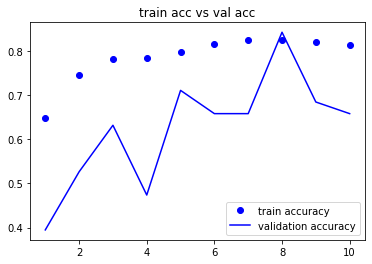

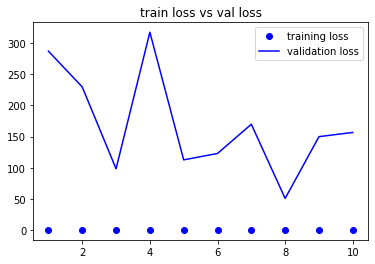

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

# Modelo 2
### Usamos transfer learning

In [4]:
from tensorflow.keras.applications import VGG16 
from tensorflow.keras import layers
from tensorflow.keras import models

Ahora bien, podemos reutilizar un modelo previamente entrenado, de esta manera podemos aprovechar que dicho modelo ya es capaz de extraer los features de las imagenes, solo quitamos la parte del clasificador (include_top = False) para poder entrenar nuestro propio clasificador para el problema especifico que queremos resolver.

In [23]:
conv_base= VGG16(weights='imagenet',
								include_top=False,
								input_shape = (150,150,3))
								
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
#model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

model.summary()

conv_base.trainable = False
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# fit model
history = model.fit(train_generator,
                    #steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    #validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 14,747,460
Trainable params: 14,747,460
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
317/317 [==============================] - 328s 1s/step - loss: 0.4260 - accuracy: 0.8399 - val_loss: 25.8411 - val_accuracy: 0.5526
Epoch 2/10
317/317 [==============================] - 332s 1s/step - loss: 0.2751 - accuracy: 0.8955 - val_loss: 19.6655 - val_accuracy: 0.6842
Epoch 3/10
317/317

Como se puede ver en el resumen de arriba o en las siguientes graficas, el accuracy de validación mejoró, sin embargo, la brecha entre val_acc y train_acc creció, lo que quiere decir que el problema de overfitting empeoró. 

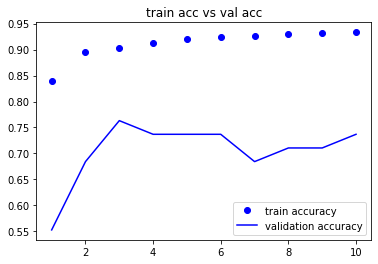

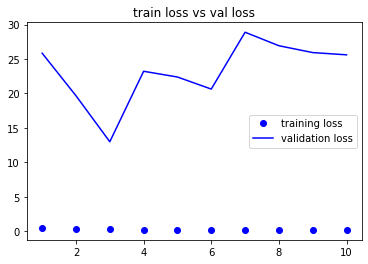

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

# Modelo 3
### Apagamos algunas neuronas en la red neuronal

- Una tecnica de regularización del modelo que podemos usar para evitar el overfitting es la de apagar algunas neuronas en cada iteración de entrenamiento del modelo. De este modo forzamos al modelo a no ajustarse a los datos de entrenamiento, y que en lugar de eso aprenda correctamente a hacer la identificación. En este caso dejaré que cada neurona tenga un 25% de probabilidad de apagarse en cada iteración
- Por otro lado agregaré una capa densa extra antes de la capa final, en dicha capa se usará la acitvación Relu
- Descongelaremos las ultimas 2 capas del modelo VGG16 para poder reentrenarlas y ver si hay alguna mejora. Esto porque dichas capas ya continen los pesos adecuados para identificar cosas más especificas, y queremos que nos ayude a un nivel más abstracto (formas, esquinas, cosas por el estilo)

In [5]:
conv_base= VGG16(weights='imagenet',
								include_top=False,
								input_shape = (150,150,3))
								
model4 = models.Sequential()
model4.add(conv_base)
model4.add(Dropout(0.25))
model4.add(layers.Flatten())
model4.add(layers.Dense(256,activation='relu'))
model4.add(layers.Dense(4,activation='softmax'))

model4.summary()

# Unfreeze the base model
conv_base.trainable = True
# Freeze all the layers before the first layer
for layer in conv_base.layers[:17]:
  layer.trainable = False

for layer in conv_base.layers:
  if layer.trainable:
    print(layer)


opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.SparseCategoricalAccuracy()
mae = tf.keras.metrics.MeanAbsoluteError()

model4.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', mae]
              )
# fit model
#with tf.device('/GPU:0'):
history4 = model4.fit(train_generator,
                    steps_per_epoch=25,
                    validation_data=val_generator,
                    #validation_steps=250,
                    epochs=15)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 16,813,124
Trainable params: 16,813,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
25/25 [==========================

¡Mejoró!
- Como se puede apreciar en la gráfica, logramos que el accuracy de validación creciera hasta llegar cerca del 90%
- El estado de overfitting prevalece, pero se ha reducido sustancialmente

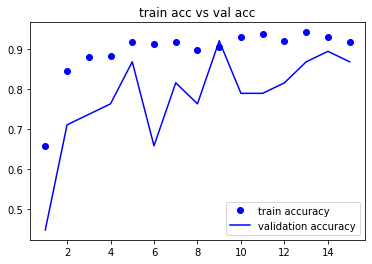

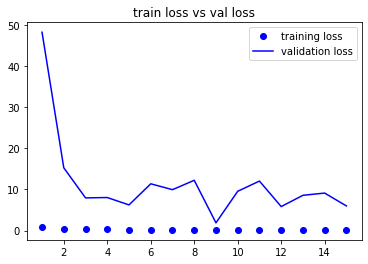

In [6]:
model4.save('my_Model.h5')
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [9]:
test_loss, test_acc, m_error= model4.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc)

25/25 [==============================] - 36s 1s/step - loss: 13.0915 - accuracy: 0.8067 - mean_absolute_error: 0.0975

test acc :
 0.8067445158958435


También obtuvimos un buen desempeño en la etapa de testeo

In [25]:
from tensorflow.keras.utils import load_img
labels = {0:'COVID19',1:'NORMAL',2:'PNEUMONIA',3:'TUBERCULOSIS'}
img = load_img('images/cobicho.jpeg', target_size = (150,150))
img = np.array(img)
img = img/255.0
img = img.reshape(1,150,150,3)
label = model4.predict(img)
index = np.argmax(label)
print('Estos rayos-X muestran que el paciente tiene: '+ labels[index])

1/1 [==============================] - 0s 210ms/step
Estos rayos-X muestran que el paciente tiene: COVID19
